In [1]:
import pymannkendall as mk
import os
import numpy as np
from netCDF4 import Dataset, num2date

In [10]:

data_dir = '../results/Modis/sst/'
varname = 'sst'
cmin, cmax = 10, 30  # Set the min and max values for the color scale
# Initialize a dictionary to hold the data for each month.
# Assuming these are the coordinates you want to crop to

# lat_min_crop, lat_max_crop = 34.3, 35.7  # Update these values as needed
# lon_min_crop, lon_max_crop = 138.3, 140.23  # Update these values as needed

lat_min_crop, lat_max_crop = 34.5, 35.4
lon_min_crop, lon_max_crop = 138.9, 139.9

# lat_min_crop, lat_max_crop = 34.4, 35.7
# lon_min_crop, lon_max_crop = 138.35, 140.2


In [11]:

# Prepare an array to store time series data for each pixel
time_series_data = {}
file_dates = []
count = 0
# Loop through files and collect time series data for each pixel
for file_name in sorted(os.listdir(data_dir)):
    if file_name.endswith('.nc'):
        count = count +1
        file_path = os.path.join(data_dir, file_name)
        with Dataset(file_path, 'r') as nc:
            lat = nc['lat'][:]
            lon = nc['lon'][:]
            sst = np.ma.squeeze(nc[varname][:])

            # Find indices for cropping
            lat_inds = np.where((lat >= lat_min_crop) & (lat <= lat_max_crop))[0]
            lon_inds = np.where((lon >= lon_min_crop) & (lon <= lon_max_crop))[0]

            # Crop data
            sst_cropped = sst[lat_inds, :][:, lon_inds]
            # mask = sst_cropped.mask
            sst_cropped = np.where(sst_cropped.mask, np.nan, sst_cropped)
            # print(sst_cropped.min(), sst_cropped.max())
            # Get time data for the file
            time = num2date(nc['time'][:], nc['time'].units)

            # Store the cropped data in the dictionary
            for i, lat_idx in enumerate(lat_inds):
                for j, lon_idx in enumerate(lon_inds):
                    if (lat_idx, lon_idx) not in time_series_data:
                        time_series_data[(lat_idx, lon_idx)] = []
                    time_series_data[(lat_idx, lon_idx)].append(sst_cropped[i, j])
            file_dates.append(time[0])
print("finished", count)

finished 255


In [174]:
file_dates

[cftime.DatetimeGregorian(2002, 7, 16, 12, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2002, 8, 19, 4, 19, 7, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2002, 9, 15, 16, 15, 52, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2002, 10, 16, 4, 17, 28, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2002, 11, 15, 16, 17, 5, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2002, 12, 16, 4, 16, 42, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2003, 1, 16, 4, 10, 55, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2003, 2, 14, 16, 7, 5, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2003, 3, 16, 4, 9, 46, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2003, 4, 15, 16, 16, 6, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2003, 5, 16, 4, 17, 10, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2003, 6, 15, 16, 50, 16, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2003, 7, 16, 4, 22, 36, 0, has_year_zero=False),
 cftime.DatetimeGregoria

In [12]:
# Perform Mann-Kendall trend test for each pixel
trend_results = np.full((len(lat_inds), len(lon_inds)), np.nan)
p_values = np.full((len(lat_inds), len(lon_inds)), np.nan)
sen_slopes = np.full((len(lat_inds), len(lon_inds)), np.nan)
trend = np.full((len(lat_inds), len(lon_inds)), "")

print(len(time_series_data.items()))
for (lat_idx, lon_idx), values in time_series_data.items():
    try:
        # Convert list of values to a numpy array
        values = np.array(values)
        valid_values = values[~np.isnan(values)]
    
        # Ensure that values are not all NaNs and there is a sufficient time series length
        if np.count_nonzero(~np.isnan(values)) > 1:  # More than one non-NaN value
            # Perform Mann-Kendall test
            # result = mk.original_test(values[~np.isnan(values)])  # Exclude NaNs for the test
            result = mk.seasonal_test(values[~np.isnan(values)])
    
            sen_slope = mk.seasonal_sens_slope(valid_values)
    
            trend[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = result.trend
            trend_results[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = result.slope
            p_values[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = result.p
            sen_slopes[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = sen_slope.slope
    
        else:
            # Not enough data to perform the test
            trend_results[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
            p_values[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
            sen_slopes[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
    except Exception as e:
        continue
# trend_results
# p_values
# sen_slopes
trend
print(trend_results)
print("finished")

8600
[[        nan         nan         nan ... -0.0034723   0.02531254
   0.31166649]
 [        nan         nan         nan ...  0.07224989 -0.00218761
   0.03750038]
 [        nan         nan         nan ... -0.08868756  0.04137497
   0.14975004]
 ...
 [ 0.10645831  0.10749992  0.10624981 ...  0.04829332  0.04330342
   0.04885415]
 [ 0.1001667   0.10600001  0.11071437 ...  0.03914664  0.05810094
   0.0253125 ]
 [ 0.09908341  0.10210529  0.10553571 ...  0.04955557  0.06141017
   0.04486927]]
finished


In [16]:
print(len(sen_slope))
sen_slopes


2


array([[        nan,         nan,         nan, ..., -0.0034723 ,
         0.02531254,  0.31166649],
       [        nan,         nan,         nan, ...,  0.07224989,
        -0.00218761,  0.03750038],
       [        nan,         nan,         nan, ..., -0.08868756,
         0.04137497,  0.14975004],
       ...,
       [ 0.10645831,  0.10749992,  0.10624981, ...,  0.04829332,
         0.04330342,  0.04885415],
       [ 0.1001667 ,  0.10600001,  0.11071437, ...,  0.03914664,
         0.05810094,  0.0253125 ],
       [ 0.09908341,  0.10210529,  0.10553571, ...,  0.04955557,
         0.06141017,  0.04486927]])

In [17]:
trend_results


array([[        nan,         nan,         nan, ..., -0.0034723 ,
         0.02531254,  0.31166649],
       [        nan,         nan,         nan, ...,  0.07224989,
        -0.00218761,  0.03750038],
       [        nan,         nan,         nan, ..., -0.08868756,
         0.04137497,  0.14975004],
       ...,
       [ 0.10645831,  0.10749992,  0.10624981, ...,  0.04829332,
         0.04330342,  0.04885415],
       [ 0.1001667 ,  0.10600001,  0.11071437, ...,  0.03914664,
         0.05810094,  0.0253125 ],
       [ 0.09908341,  0.10210529,  0.10553571, ...,  0.04955557,
         0.06141017,  0.04486927]])

In [131]:
def mask_values(data, mask_value, mask_color):
  """
  Masks values greater than a threshold with a specific color.

  Args:
      data: The data to be masked.
      mask_value: The threshold value for masking.
      mask_color: The color to use for masking.

  Returns:
      A masked data array and a colormap with the masked color added.
  """
  masked_data = np.where(data > mask_value, mask_color, data)
  cmap_list = ['gray', mask_color] + rgb_colors[1:]  # Add mask color after gray
  custom_colormap = LinearSegmentedColormap.from_list('custom', cmap_list)
  return masked_data, custom_colormap


In [7]:
p_values

array([[           nan,            nan,            nan, ...,
        6.95609480e-01, 9.42279716e-01, 8.18838345e-01],
       [           nan,            nan,            nan, ...,
        1.48272636e-02, 6.56481166e-02, 9.21886184e-01],
       [           nan,            nan,            nan, ...,
        5.21581233e-02, 3.00861803e-01,            nan],
       ...,
       [1.94201478e-03, 6.79488826e-03, 1.16697617e-02, ...,
        2.48672499e-02, 1.08480852e-02, 1.02515503e-02],
       [2.99264995e-03, 2.81466815e-03, 5.39336638e-03, ...,
        1.51187784e-02, 3.31213123e-02, 4.43918225e-02],
       [2.99264995e-03, 1.61355818e-03, 3.45127920e-04, ...,
        4.64865822e-02, 3.03292894e-02, 7.87710639e-02]])

[[           nan            nan            nan ... 9.64434562e-01
  7.83030948e-01 3.97674585e-01]
 [           nan            nan            nan ... 2.89991941e-01
  1.00000000e+00 9.06897951e-01]
 [           nan            nan            nan ... 4.96649798e-01
  7.66156610e-01 6.33362801e-01]
 ...
 [9.90318938e-13 1.18748995e-08 1.68996706e-08 ... 1.39590382e-02
  2.40990127e-01 2.56351478e-01]
 [1.17310828e-10 1.54863455e-09 3.57035030e-08 ... 1.88990927e-01
  5.55694757e-04 3.82748886e-01]
 [8.33362268e-11 7.40267927e-08 3.21653815e-12 ... 1.94962054e-01
  6.16165806e-02 3.70506394e-01]]


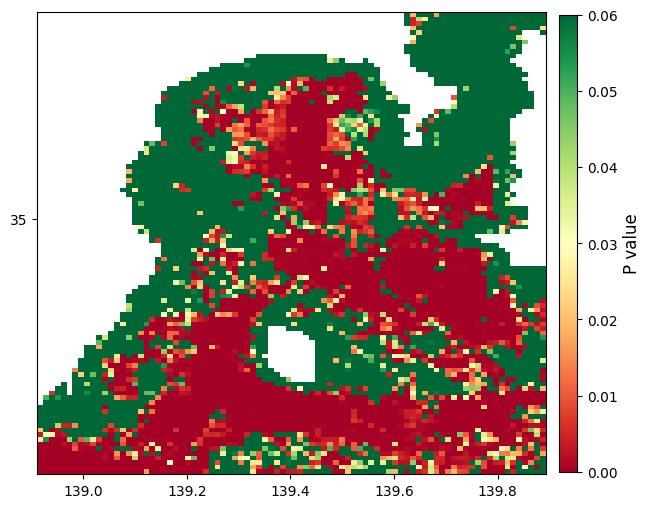

In [13]:
# Plot the results
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plot, colors
from matplotlib.colors import LinearSegmentedColormap
print(p_values)
# Create a Basemap instance
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=lat[lat_inds[0]], urcrnrlat=lat[lat_inds[-1]],
            llcrnrlon=lon[lon_inds[0]], urcrnrlon=lon[lon_inds[-1]])

# Create a grid of coordinates
lon_grid, lat_grid = np.meshgrid(lon[lon_inds], lat[lat_inds])
rgb_colors = ["blue","green","lightgreen", "yellow", "orange", "#FF474C", "red"]

fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio
extent = [lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()]
ax.imshow(p_values, cmap='gray',  extent=extent)

# Create a colormap object
custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

# mark light blue for values greater than 0.05

# Create a grid of coordinates
lon_grid, lat_grid = np.meshgrid(lon[lon_inds], lat[lat_inds])
# rgb_colors = ["red","blue","green","lightgreen", "yellow", "orange"]
# custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)
# masked_p_values, custom_colormap = mask_values(p_values, 0.06, "red")

# ims = ax.imshow(masked_p_values, vmin=0, vmax=0.05, cmap=custom_colormap, extent=extent)

# ims = ax.imshow(trend_results,vmin=cmin, vmax=cmax,  extent=extent)
ims = ax.imshow(p_values,  vmin=0, vmax=0.06,cmap="RdYlGn",  extent=extent)

# # Figure labels
# ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
# ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
ax.set_yticks(range(int(np.ceil(lat_grid.min())), int(np.ceil(lat_grid.max())), 1))
# ax.set_title(time[0].strftime('%b %Y'))

# # Colourbar
cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=26)
# cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")
cbar.set_label('P value', fontsize="12")

# ticks = [ims.get_clim()[0],0, ims.get_clim()[1]] # This gets the color limit range
# cbar.set_ticks(ticks)
# cbar.set_ticklabels([f'{ticks[0]:.2f}', f'{ticks[1]:.2f}', f'{ticks[2]:.2f}']) # Format as desired
plt.savefig(f'trend/modis_sst_pvalues2_modified.png', dpi=300, bbox_inches='tight')

plt.show()


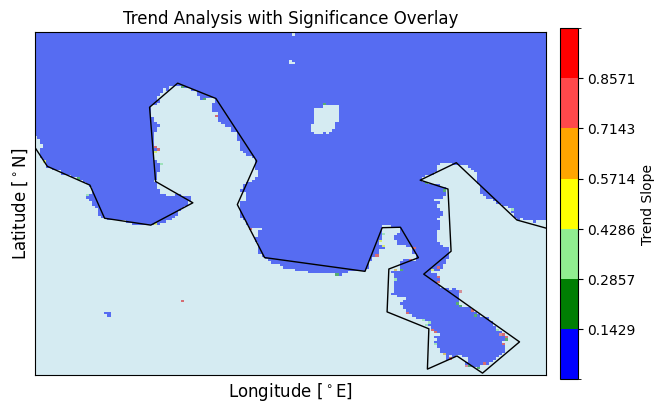

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm

# Assuming p_values is your array of p-values
# Assuming trend_results is your array of trend values (e.g., Sen's slope)

# Create a Basemap instance
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=lat[lat_inds[0]], urcrnrlat=lat[lat_inds[-1]],
            llcrnrlon=lon[lon_inds[0]], urcrnrlon=lon[lon_inds[-1]])

# Create a grid of coordinates
lon_grid, lat_grid = np.meshgrid(lon[lon_inds], lat[lat_inds])

# Define your colormap for significant trends
rgb_colors = ["blue", "green", "lightgreen", "yellow", "orange", "#FF474C", "red"]
custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

# Set the bounds for the colormap
bounds = np.linspace(0, 1, len(rgb_colors) + 1)
norm = BoundaryNorm(bounds, custom_colormap.N)

# Plot the trend results with the custom colormap
fig, ax = plt.subplots(figsize=(7, 6))
m.drawcoastlines()
trend_im = m.pcolormesh(lon_grid, lat_grid, trend_results, cmap=custom_colormap, norm=norm, latlon=True)

# Overlay non-significant trends in light blue
# Mask significant trends (p < 0.05), so non-significant trends are shown
non_sig_mask = np.ma.masked_greater(p_values, 0.05).mask
m.pcolormesh(lon_grid, lat_grid, non_sig_mask, cmap=ListedColormap(['lightblue']), alpha=0.5, latlon=True)

# Add color bar
cbar = plt.colorbar(trend_im, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025, spacing='proportional', ticks=bounds[1:-1])
cbar.set_label('Trend Slope')

ax.set_xlabel('Longitude [$^\circ$E]', fontsize="12")
ax.set_ylabel('Latitude [$^\circ$N]', fontsize="12")

plt.title('Trend Analysis with Significance Overlay')
plt.show()


In [266]:
print(sen_slopes)
sen_slopes.max()
# sen_slopes = sen_slopes *12*10


[[        nan         nan         nan ... -0.03751172 -0.02053318
  -0.08684826]
 [        nan         nan         nan ... -0.27181635 -0.61759245
   0.46253693]
 [        nan         nan         nan ...  0.35189227  0.38913703
          nan]
 ...
 [-0.00602542 -0.00545088 -0.00526447 ... -0.00179853 -0.00238949
  -0.00217247]
 [-0.00491834 -0.00536218 -0.00533    ... -0.00209069 -0.00174798
  -0.00159517]
 [-0.00441608 -0.00502512 -0.00566973 ... -0.00187202 -0.00218952
  -0.00185681]]


nan

[[        nan         nan         nan ... -0.0034723   0.02531254
   0.31166649]
 [        nan         nan         nan ...  0.07224989 -0.00218761
   0.03750038]
 [        nan         nan         nan ... -0.08868756  0.04137497
   0.14975004]
 ...
 [ 0.10645831  0.10749992  0.10624981 ...  0.04829332  0.04330342
   0.04885415]
 [ 0.1001667   0.10600001  0.11071437 ...  0.03914664  0.05810094
   0.0253125 ]
 [ 0.09908341  0.10210529  0.10553571 ...  0.04955557  0.06141017
   0.04486927]]


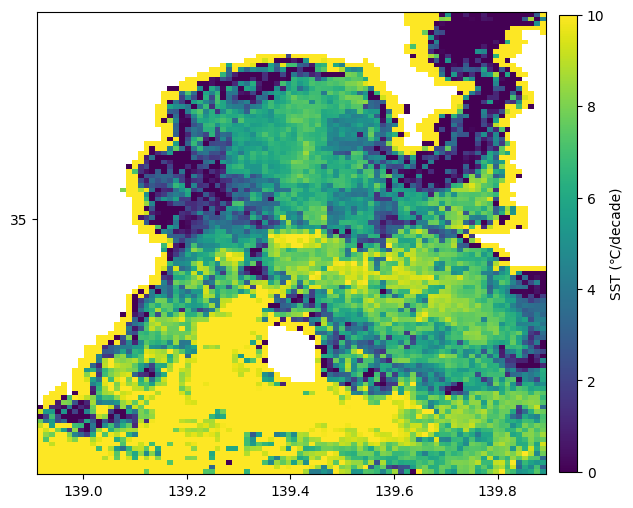

In [26]:

print(sen_slopes)
# sen_slopes = trend_results
# sen_slopes = sen_slopes * 12*10
fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio
extent = [lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()]
# ax.imshow(sen_slopes, cmap='gray', vmin=0, vmax=1, extent=extent)
# Create a colormap object
# custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

# ims = ax.imshow(trend_results,vmin=cmin, vmax=cmax,  extent=extent)
ims = ax.imshow(sen_slopes*12*10,  vmin=0, vmax=10, extent=extent)
# ims = ax.imshow(sen_slopes,vmin=0, vmax=1,  cmap=custom_colormap, extent=extent)

# # Figure labels
# ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
# ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
ax.set_yticks(range(int(np.ceil(lat_grid.min())), int(np.ceil(lat_grid.max())), 1))
# ax.set_title(time[0].strftime('%b %Y'))

# # Colourbar
cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=26)
cbar.set_label('SST (℃/decade)')
# cbar.set_label('Chl (mg/m^3)')

# Small Sagami Bay
lat_min, lat_max = 35.124, 35.34
lon_min, lon_max = 139.115, 139.68
plt.savefig(f'trend/seasonal_slope_sst_modis_____sss.png', dpi=300, bbox_inches='tight')
plt.show()
